# Discretization

In this notebook, you will deal with continuous state/action spaces by discretizing them. This will enable you to apply reinforcement learning algorithms that are only designed to work with discrete spaces.

> **Tip**: You can run each code block below by pressing **`Shift+Enter`**. Look for any **`TODO`** comments and implement the indicated code. Also try to answer any questions (**Q:**) by editing the corresponding answer (**A:**) block.

In [1]:
# Import common libraries
import gym
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.

> **Note**: You can run this notebook locally (use `render_mode = 'desktop'`), or in an online workspace / cloud instance (use `render_mode = 'jupyter'`, to visualize the simulation within the notebook). But visualization can be quite slow (esp. in the notebook), so you may want to set it to `None` to suppress visualization when you're ready to run a long batch. It is always recommended to download and run the notebook on your local machine.

In [2]:
# Global render settings
render_mode = None  # set to 'desktop' (when running on local machine) or 'jupyter' (in notebook, slow)

# Start a virtual display if you wish to render within the jupyter notebook (needed for certain envs)
if render_mode == 'jupyter':
    !pip install pyvirtualdisplay  # install pyvirtualdisplay, one-time only
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0)
    virtual_display.start()

## Continuous State Space

Let's begin with an environment that has a continuous state space, but a discrete action space.

In [3]:
# Create an environment
env = gym.make('MountainCar-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Now we can explore the state and action spaces, as well as sample them.

In [4]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

State space: Box(2,)
- low: [-1.2  -0.07]
- high: [0.6  0.07]


In [5]:
# Generate some samples from state space (if the space is finite)
if np.all(np.isfinite(env.observation_space.low)) and np.all(np.isfinite(env.observation_space.high)):
    print("State space samples:")
    print(np.array([env.observation_space.sample() for i in range(10)]))

State space samples:
[[-0.212  0.03 ]
 [-0.115  0.006]
 [-0.437  0.02 ]
 [-0.412  0.055]
 [ 0.535 -0.016]
 [ 0.225  0.004]
 [-0.178  0.06 ]
 [-1.072 -0.058]
 [-1.164  0.047]
 [ 0.201  0.052]]


In [6]:
# Explore action space
print("Action space:", env.action_space)

# Generate some samples from action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

Action space: Discrete(3)
Action space samples:
[2 0 1 1 2 0 1 1 1 0]


## Uniform Grid

The first approach we'll try is to discretize the space using a uniformly-spaced grid. Implement the following function to create such a grid, given the lower bounds (`low`), upper bounds (`high`), and number of desired `bins` along each dimension. It should return the split points for each dimension, which will be 1 less than the number of bins.

E.g. if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, and `bins = (10, 10)`, then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[[-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8],
 [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]]
```

Note that the ends of `low` and `high` are **not** included in these split points. It is assumed that any value below the lowest split point maps to index `0` and any value above the highest split point maps to index `n-1`, where `n` is the number of bins along that dimension.

In [7]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    #print(low)
    #print(high)
    result = []
    for l,h,b in zip(low, high, bins):
        print(l,h,b)
        step = (h - l) / b
        print(step)
        if( step == 0 ):
            result.append(np.full(b - 1,l))
        else:
            result.append(np.arange(l + step, h, step, dtype=None))
    return result
    #step = (np.array(high)-np.array(low))/bins       
    #return tuple(np.arange(low[i] + step[i], high[i], step[i]) for i in range(step.size))


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

-1.0 1.0 10
0.2
-5.0 5.0 10
1.0


[array([-8.00e-01, -6.00e-01, -4.00e-01, -2.00e-01, -2.22e-16,  2.00e-01,  4.00e-01,  6.00e-01,  8.00e-01]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

Now write a function that can convert samples from a continuous space into its equivalent discretized representation, given a grid like the one you created above. You can use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.

Assume the grid is a NumPy array containing the following split points:
```
[[-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8],
 [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]]
```

Here are some potential samples and their corresponding discretized representations:
```
[-1.0 , -5.0] => [0, 0]
[-0.81, -4.1] => [0, 0]
[-0.8 , -4.0] => [1, 1]
[-0.5 ,  0.0] => [2, 5]
[ 0.2 , -1.9] => [6, 3]
[ 0.8 ,  4.0] => [9, 9]
[ 0.81,  4.1] => [9, 9]
[ 1.0 ,  5.0] => [9, 9]
```

Note: There may be one-off differences in binning due to floating-point inaccuracies when samples are close to grid boundaries, but that is alright.

In [8]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    result = []
    for s,g in zip(sample, grid):
        result.append(np.digitize(s, g))
    return result


# Test with a simple grid and some samples
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

-1.0 1.0 10
0.2
-5.0 5.0 10
1.0

Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [6, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


## Visualization

It might be helpful to visualize the original and discretized samples to get a sense of how much error you are introducing.

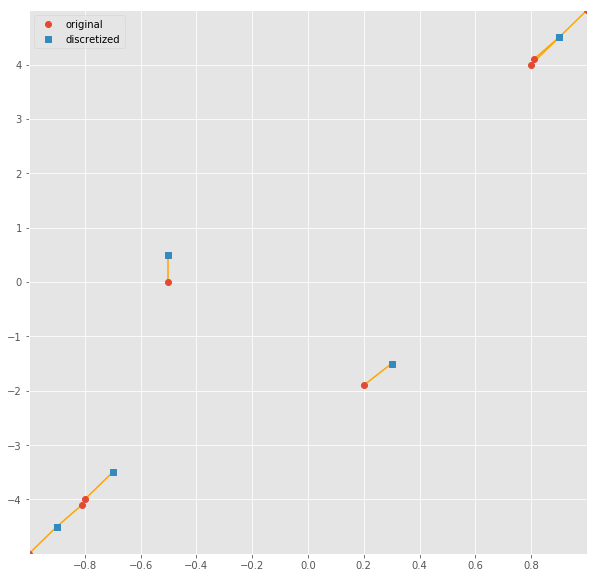

In [9]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])


visualize_samples(samples, discretized_samples, grid, low, high)

Now that we have a way to discretize a state space, let's apply it to our reinforcement learning environment.

In [10]:
# Create a grid to discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))
state_grid

-1.2 0.6 10
0.18000000715255737
-0.07 0.07 10
0.014000000059604644


[array([-1.02, -0.84, -0.66, -0.48, -0.3 , -0.12,  0.06,  0.24,  0.42]),
 array([-5.600e-02, -4.200e-02, -2.800e-02, -1.400e-02,  6.939e-18,  1.400e-02,  2.800e-02,  4.200e-02,  5.600e-02])]

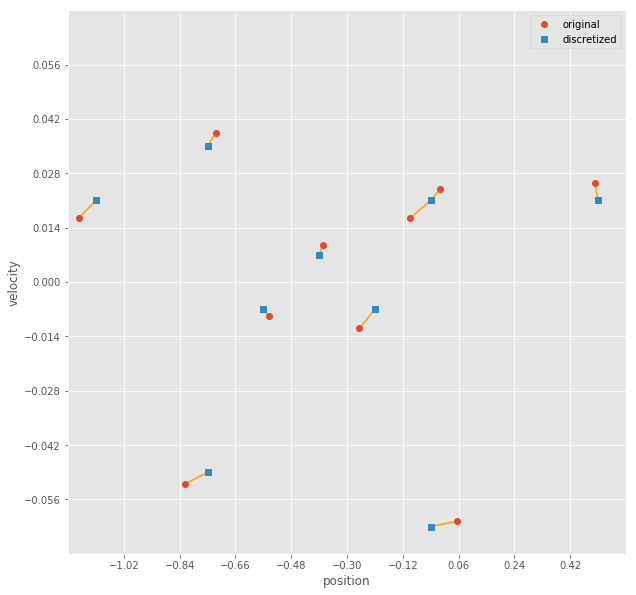

In [11]:
# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position'); plt.ylabel('velocity');  # axis labels for MountainCar-v0 state space

What you might've noticed is that if you have enough bins, the discretization doesn't introduce too much error into your representation. So we may be able to now apply a reinforcement learning algorithm (like Q-Learning) that operates on discrete spaces. Give it a shot to see how well it works!

## Q-Learning

Provided below is a simple Q-Learning agent. Implement the `preprocess_state()` method to convert each continuous state sample to to its corresponding discretized representation.

In [12]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid,
                 alpha=0.2, gamma=0.9,
                 epsilon=0.5, epsilon_decay_rate=0.99):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon

        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        result = discretize(state, self.state_grid)
        return (result[0].item(0), result[1].item(0))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action


q_agent = QLearningAgent(env, state_grid)

Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)


Let's also define a convenience function to run an agent on a given environment. We can then reuse it later.

> **Note**: When calling this function, you can pass in `mode='test'` to tell the agent not to learn. You can also pass in `render_mode=render_mode` to use the global mode defined earlier, or override it, e.g. to suppress visualization altogether, use `render_mode=None`.

In [13]:
def run(agent, env, num_episodes=1000, mode='train',
        render_mode='desktop', render_every=100, jupyter_frame_interval=15):
    """Run agent in given reinforcement learning environment and return episode rewards."""
    episode_rewards = []

    try:
        for e in tqdm(range(num_episodes), disable=(render_mode=='jupyter')):
            # Initialize episode
            state = env.reset()
            action = agent.reset_episode(state)
            t = 0
            total_reward = 0
            done = False

            if render_mode == 'jupyter':
                img = plt.imshow(env.render(mode='rgb_array'))  # [jupyter] one-time only
                plt.axis('off')

            # Roll out steps till done
            while not done:
                state, reward, done, info = env.step(action)
                total_reward += reward
                action = agent.act(state, reward, done, mode)
                if render_mode and e % render_every == 0:  # only display certain episodes
                    if render_mode == 'jupyter':
                        if t % jupyter_frame_interval == 0:
                            img.set_data(env.render(mode='rgb_array'))  # [jupyter] just update the data
                            display.display(plt.gcf())
                            display.clear_output(wait=True)
                    else:
                        env.render(mode='human', close=done)
                t += 1

            # Collect episode reward
            episode_rewards.append(total_reward)
    except KeyboardInterrupt:
        pass
    finally:
        if render_mode:
            env.render(close=True)

    return episode_rewards


episode_rewards = run(q_agent, env, num_episodes=1000, render_every=100, render_mode=render_mode)
print("Completed {} episodes with avg. reward = {}".format(len(episode_rewards), np.mean(episode_rewards)))

100%|██████████| 1000/1000 [00:10<00:00, 98.35it/s]

Completed 1000 episodes with avg. reward = -195.078


The best way to analyze if your agent was learning the task is to plot episode rewards. It should generally increase as the agent goes through more episodes.

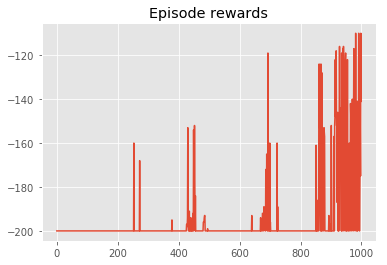

In [14]:
# Plot rewards obtained per episode
plt.plot(episode_rewards); plt.title("Episode rewards");

If the episode rewards are noisy, it might be difficult to tell whether your agent is actually learning. To find the underlying trend, you may want to plot a rolling mean of the episode rewards. Let's write a convenience function to plot both raw rewards as well as a rolling mean.

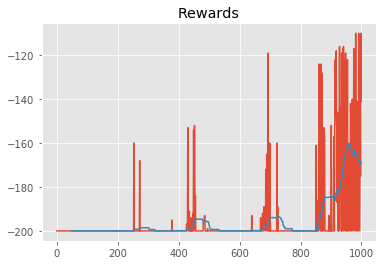

In [15]:
def plot_rewards(rewards, rolling_window=None):
    """Plot rewards and optional rolling mean using specified window."""
    plt.plot(rewards); plt.title("Rewards");
    if rolling_window is not None:
        plt.plot(pd.Series(rewards).rolling(rolling_window).mean());


window_size = 50  # choose a suitable window size, e.g. int(len(episode_rewards) / 25)
plot_rewards(episode_rewards, rolling_window=window_size)

If you haven't yet reached a desired level of performance, try training your agent a few more times.

100%|██████████| 1000/1000 [00:08<00:00, 114.28it/s]


Completed 20019 total episodes with avg. reward = -190.57110744792448


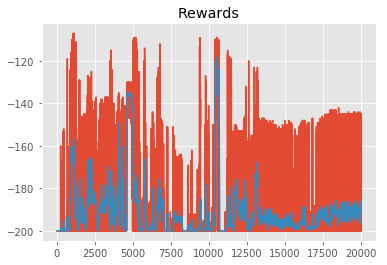

In [25]:
# Run in training mode for some more episodes and analyze rewards
# Note: In this case, we want to keep the entire history of episode rewards
episode_rewards += run(q_agent, env, num_episodes=1000, render_mode=None)
print("Completed {} total episodes with avg. reward = {}".format(len(episode_rewards), np.mean(episode_rewards)))
plot_rewards(episode_rewards, rolling_window=window_size)

You should observe the mean episode rewards go up over time. Finally, you can freeze learning and run the agent in test mode to see how well it performs.

100%|██████████| 100/100 [00:00<00:00, 149.58it/s]


[TEST] Completed 100 episodes with avg. reward = -192.07


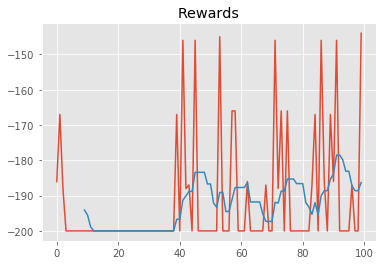

In [26]:
# Run in test mode and analyze rewards obtained
test_rewards = run(q_agent, env, num_episodes=100, mode='test', render_mode=render_mode, render_every=10)
print("[TEST] Completed {} episodes with avg. reward = {}".format(len(test_rewards), np.mean(test_rewards)))
plot_rewards(test_rewards, rolling_window=10)

It's also interesting to look at the final Q-table that is learned by the agent. Note that the Q-table is of size MxNxA, where (M, N) is the size of the state space, and A is the size of the action space. We are interested in the maximum Q-value for each state, and the corresponding (best) action associated with that value.

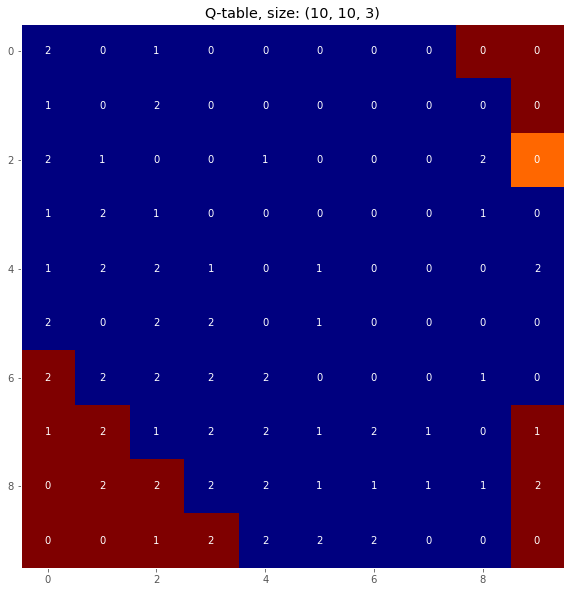

In [27]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)  # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(q_image, cmap='jet');
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))


plot_q_table(q_agent.q_table)

## Exercise: Modify Grid

Now it's your turn to play with the grid definition and see what gives you optimal results. Your agent's final performance is likely to get better if you use a finer grid, with more bins per dimension, at the cost of higher model complexity (more parameters to learn).

In [28]:
# TODO: Create a new agent with a different state space grid
state_grid_new = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(100, 100))
q_agent_new = QLearningAgent(env, state_grid_new)
q_agent_new.episode_rewards = []  # initialize a list to store episode rewards for this agent

-1.2 0.6 100
0.01800000071525574
-0.07 0.07 100
0.0014000000059604645
Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (100, 100)
Action space size: 3
Q table size: (100, 100, 3)


100%|██████████| 1000/1000 [00:09<00:00, 109.61it/s]


Completed 1000 total episodes with avg. reward = -200.0


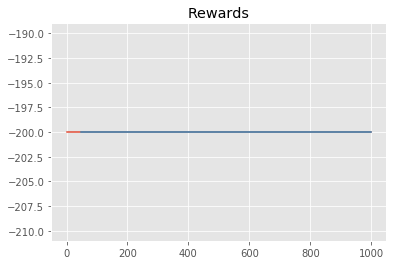

In [29]:
# Train it over a desired number of episodes and analyze rewards
# Note: This cell can be run multiple times, and episode rewards will get accumulated
q_agent_new.episode_rewards += run(q_agent_new, env, num_episodes=1000, render_mode=None)  # accumulate episode rewards
print("Completed {} total episodes with avg. reward = {}".format(
    len(q_agent_new.episode_rewards), np.mean(q_agent_new.episode_rewards)))
plot_rewards(q_agent_new.episode_rewards, rolling_window=window_size)

100%|██████████| 100/100 [00:00<00:00, 119.95it/s]

[TEST] Completed 100 episodes with avg. reward = -200.0


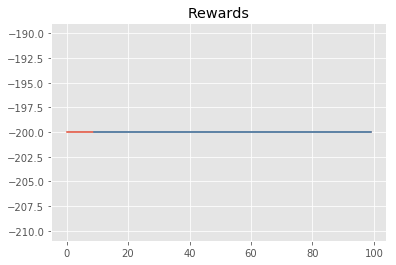

In [30]:
# Run in test mode and analyze rewards obtained
test_rewards = run(q_agent_new, env, num_episodes=100, mode='test', render_mode=render_mode, render_every=10)
print("[TEST] Completed {} episodes with avg. reward = {}".format(len(test_rewards), np.mean(test_rewards)))
plot_rewards(test_rewards, rolling_window=10)

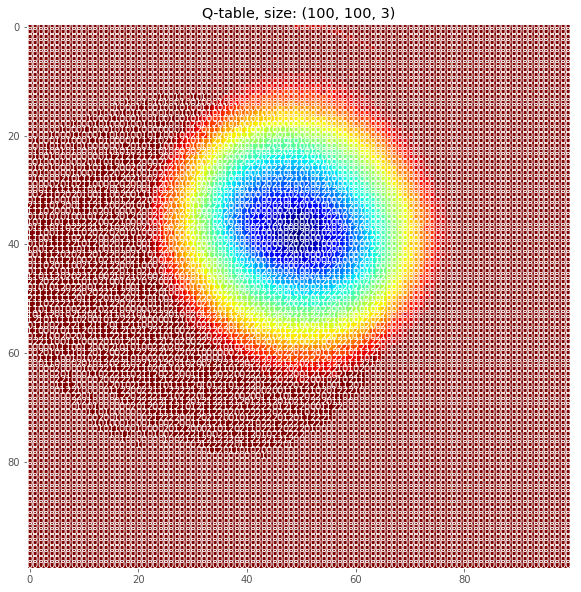

In [31]:
# Visualize the learned Q-table
plot_q_table(q_agent_new.q_table)

**Q**: What conclusions can you draw from this exercise?
- Is discretization an effective way to deal with continuous state spaces?
- How is the learning and final performance of the agent affected by whether you choose a finer or coarser grid?

**A**:


## Nonuniform Grid

Now let's try to apply the same discretization technique to a different environment, say one with a continuous state space that has more than 2 dimensions. We'll still limit ourselves to a discrete action space for simplicity.

You can refer to this [table of environments](https://github.com/openai/gym/wiki/Table-of-environments) on the OpenAI Gym Wiki to choose a suitable one, e.g. `CartPole-v0` which has a 4-dimensional state space (see [wiki page](https://github.com/openai/gym/wiki/CartPole-v0) for details on what each dimension means).

In [32]:
# Choose an environment with a higher dimensional continuous state space, but discrete action space
env2 = gym.make('CartPole-v0')

# Also make sure that the state space has definite lower and upper bounds - necessary to create a uniform grid
print("State space:", env2.observation_space)
print("- low:", env2.observation_space.low)
print("- high:", env2.observation_space.high)
print("Action space:", env2.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State space: Box(4,)
- low: [-4.800e+00 -3.403e+38 -4.189e-01 -3.403e+38]
- high: [4.800e+00 3.403e+38 4.189e-01 3.403e+38]
Action space: Discrete(2)


In [33]:
# Create an agent and initialize episode rewards list
state_grid2 = create_uniform_grid(env2.observation_space.low, env2.observation_space.high, bins=(10, 10))
q_agent2 = QLearningAgent(env2, state_grid2)
q_agent2.episode_rewards = []

-4.8 4.8 10
0.9600000381469727
-3.4028235e+38 3.4028235e+38 10
inf


/Users/scrier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in float_scalars
/Users/scrier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


ValueError: arange: cannot compute length

If you notice carefully, you'll see that the `low` and `high` limits for some dimensions are very large in magnitude (at least this is the case for `CartPole-v0`). This results in a discretization grid that may not work very well for the task.

To get a better sense of the values we might expect to get, let's sample the state space, and plot the values obtained for each dimension separately as a histogram.

In [ ]:
# Check distribution of state space values for each dimension
state_samples = np.array([env2.observation_space.sample() for i in range(1000)])
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for dim in range(state_samples.shape[1]):
    axes[dim // 2, dim % 2].hist(state_samples[:, dim], bins=20)

These look like uniform distributions across the specified [`low`, `high`] ranges, don't they? But are they really representative of what values we'll see when running the environment? Perhaps not. To be sure, let's simulate running a random agent interacting with the environment and collect all the state values observed.

In [ ]:
def get_state_samples(env, num_steps=1000):
    """Run environment with random actions to get realistic set of state samples."""
    env.reset()
    state_samples = []
    for i in range(num_steps):
        state, reward, done, info = env.step(env.action_space.sample())  # random action
        state_samples.append(state)
        if done:
            env.reset()
    return np.array(state_samples)


state_samples = get_state_samples(env2)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for dim in range(state_samples.shape[1]):
    ax = axes[dim // 2, dim % 2]
    ax.hist(state_samples[:, dim], bins=20)
    ax.set_title("dim #{}".format(dim))

Now we can clearly see that although the declared range for each dimension is fairly wide, the values observed in practice follow a distribution close to normal, often centered on zero or some other commonly-occuring value. In fact, for some environments, the declared range can be `(-inf, +inf)`, and yet the actual values produced might be very limited.

If you have prior knowledge about the environment, you can manually specify the split points for the discretization grid to use. However, a more robust approach is to use samples obtained by simulating the environment to come up with a nonuniform grid that optimizes where you place the split points.

### Quantiles

_Quantiles_ of a sample are partitions that contain an equal number of values. You may be familiar with _percentile_, which is a type of quantile. Each percentile contains 1% of the total number of values. In other words, percentiles split the entire range of a given sample of values into 100 buckets such that each bucket contains the same number of values.

Similarly, _quartiles_ split a sample into 4 equal-size buckets. And this idea is generalized to quantiles, where you get to specify the number of buckets or bins you want. Let's look at an example. We'll draw samples from a standard normal distribution (mean = 0, variance = 1), plot their histogram, and then change the X-axis ticks to 10-quantiles.

In [ ]:
# Draw samples from a Normal distribution and plot their histogram
samples = stats.norm.rvs(loc=0.0, scale=1.0, size=1000)
plt.figure(figsize=(16, 9))
plt.hist(samples, bins=20);

# Compute quantiles and set X-axis ticks
quantiles = pd.Series(samples).quantile(np.linspace(0.0, 1.0, 10))
plt.xticks(quantiles);

As you can see, this allows us to have more resolution where required, and helps us avoid having to represent the entire declared range of the state space, which can be `[-inf, +inf]`.

Use this idea to implement the following function. Note that you should still follow the same convention as before, i.e., given no. of bins = 10 for some dimension, you should return 9 split points.

In [ ]:
def create_nonuniform_grid(samples, bins=(10, 10)):
    """Define a nonuniform grid for discretizing a space characterized by given samples."""
    # TODO: Implement this
    pass


state_grid2 = create_nonuniform_grid(state_samples, bins=(10, 10, 10, 10))
print("Nonuniform grid: [<low>, <high>] / <bins> => <splits>")
for l, h, splits in zip(env2.observation_space.low, env2.observation_space.high, state_grid2):
    print("    [{:.3g}, {:.3g}] / {} => {}".format(l, h, len(splits) + 1, splits))

Visualize the state samples with this new grid. Labels might be hard to see, but make sure the grid spacing covers the state space as desired.

In [ ]:
# Visualize state samples with non-uniform grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for dim in range(state_samples.shape[1]):
    ax = axes[dim // 2, dim % 2]
    ax.hist(state_samples[:, dim], bins=20)
    ax.set_title("dim #{}".format(dim))
    ax.set_xticks(state_grid2[dim])

Now redefine your agent using the new grid, train it, and see if the grid enables the agent to learn the task properly.

In [ ]:
# Redefine agent using new non-uniform grid
#state_samples = get_state_samples(env2, num_steps=1000)  # get state samples
#state_grid2 = create_nonuniform_grid(state_samples, bins=(20, 20, 20, 20))  # define a non-uniform grid
q_agent2 = QLearningAgent(env2, state_grid2)
q_agent2.episode_rewards = []

In [ ]:
# Train agent and plot rewards (accumulate episode rewards on each run)
q_agent2.episode_rewards += run(q_agent2, env2, num_episodes=10000, render_mode=None)
print("Completed {} total episodes with avg. reward = {}".format(
    len(q_agent2.episode_rewards), np.mean(q_agent2.episode_rewards)))
plot_rewards(q_agent2.episode_rewards, rolling_window=window_size)

How did it do? Try training for some more iterations. And if needed, experiment with different grid sizes and/or samples to use when building the grid.

In [ ]:
# Run in test mode and analyze rewards obtained
test_rewards = run(q_agent2, env2, num_episodes=100, mode='test', render_mode=render_mode, render_every=10)
print("[TEST] Completed {} episodes with avg. reward = {}".format(len(test_rewards), np.mean(test_rewards)))
plot_rewards(test_rewards, rolling_window=10)

Try looking the Q-table of your trained agent. Note that you will have to choose 2 state dimensions to visualize, which means you will need to aggregate over the remaining dimensions. One way of aggregating would be to compute the average Q-value across all those dimensions.

In [ ]:
# Visualize Q-table
agg_dims = (1, 3)  # dimensions of Q-table to aggregate over
q_table_agg = np.average(q_agent2.q_table, axis=agg_dims)  # aggregated q_table
plot_q_table(q_table_agg)

**Q**: What did you learn from this exercise?
- Is this method of sampling a viable way to deal with state spaces that have unknown bounds or distributions?
- Did you need to use a coarser or finer grid?
- Was this new problem easier or harder to learn?
- Would you be able to manually design a better grid based on your knowledge of the environment?

**A**:


## References

To learn about more advanced discretization approaches, refer to the following:

- Uther, W., and Veloso, M., 1998. [Tree Based Discretization for Continuous State Space Reinforcement Learning](http://www.cs.cmu.edu/~mmv/papers/will-aaai98.pdf). In _Proceedings of AAAI, 1998_, pp. 769-774.
- Munos, R. and Moore, A., 2002. [Variable Resolution Discretization in Optimal Control](https://link.springer.com/content/pdf/10.1023%2FA%3A1017992615625.pdf). In _Machine Learning_, 49(2), pp. 291-323.